## Tracks ripple participation probability over epochs

In [1]:
%cd ..
import pandas as pd
import numpy as np 
import glob
import matplotlib.pyplot as plt

# import hdf5storage
# import h5py
# import scipy.io as sio

import sys,os
import seaborn as sns

import functions,loading

import nelpy as nel  # main nelpy imports
# import nelpy.plotting as npl  # optional plotting import

import math
import itertools
from scipy import stats
import multiprocessing
from joblib import Parallel, delayed
from scipy.ndimage import gaussian_filter1d
from sklearn.linear_model import LinearRegression
import matplotlib


d:\github\ripple_heterogeneity\python


C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\plotting\decoding.py:9: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.


In [2]:
tex_fonts = {
#     # Use LaTeX to write all text
#     "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "svg.fonttype": 'none'
}
plt.style.use('seaborn-paper')
# plt.style.use('dark_background')

plt.rcParams.update(tex_fonts)

# plt.rcParams['svg.fonttype'] = 'none'

%config InlineBackend.figure_format = 'retina'

fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\project_log'

In [3]:
def compress_repeated_epochs(epoch_df):
    match = np.zeros([epoch_df.environment.shape[0]])
    match[match == 0] = np.nan
    for i,ep in enumerate(epoch_df.environment[:-1]):
        if np.isnan(match[i]):
            # find match in current and next epoch
            if ep == epoch_df.environment.iloc[i+1]:
                match[i:i+2] = i
                # given match, see if there are more matches
                for match_i in np.arange(1,epoch_df.environment[:-1].shape[0]):
                    if i+1+match_i == epoch_df.environment.shape[0]:
                        break
                    if ep == epoch_df.environment.iloc[i+1+match_i]:

                        match[i:i+1+match_i+1] = i
                    else:
                        break

    for i in range(len(match)):
        if np.isnan(match[i]):
            match[i] = (i+1)*2000 # make nans large numbers that are unlikely to be real epoch

    # iter through each epoch indicator to get start and stop
    results = pd.DataFrame()
    no_nan_match = match[~np.isnan(match)]
    for m in pd.unique(no_nan_match):
        temp_dict = {'name': epoch_df[match==m].name.iloc[0],
                    'startTime':epoch_df[match==m].startTime.iloc[0],
                    'stopTime':epoch_df[match==m].stopTime.iloc[-1],
                    'environment':epoch_df[match==m].environment.iloc[0],
                    'behavioralParadigm':epoch_df[match==m].behavioralParadigm.iloc[0],
    }
        temp_df = pd.DataFrame.from_dict(temp_dict,orient='index').T

        results = results.append(temp_df,ignore_index=True)
    return results
    
def load_basic_data(basepath):
    nChannels, fs, fs_dat, shank_to_channel = functions.loadXML(basepath)
    ripples = loading.load_ripples_events(basepath)
    cell_metrics,data = loading.load_cell_metrics(basepath)
    return cell_metrics,data,ripples,fs_dat

def get_participation(st,ripple_epochs):
    # get participation prob.
    # make matrix n rows (units) by n cols (ripple epochs)
    unit_mat = np.zeros((st.n_units,ripple_epochs.n_intervals))
    for i,event in enumerate(st):
        unit_mat[:,i] = (event.n_events>0)*1
    return unit_mat

def main_analysis(basepath,cell_metrics,st_unit,ripple_epochs,behavioral_epochs,epoch_df):

    # create empty dataframe to add metrics from each epoch
    df_save = pd.DataFrame()

    # create spike train object with ripple epochs
    st_unit_rip = st_unit[ripple_epochs]

    epochs = epoch_df.environment
    familiarity = epoch_df.behavioralParadigm

    for i,ep in enumerate(behavioral_epochs):
        temp_save = pd.DataFrame()

        unit_mat = get_participation(st_unit_rip[ep],
                                        ripple_epochs[ep])

        participation_prob = np.sum(unit_mat,axis=1) / unit_mat.shape[1]

        try:
            avg_fr_not_rip = st_unit[~ripple_epochs][ep].n_spikes / ep[~ripple_epochs].duration
            avg_fr_in_rip = st_unit_rip[ep].n_spikes / st_unit_rip[ep].support.duration
            n_spikes = st_unit[ep].n_spikes
        except:
            avg_fr_not_rip = np.nan
            avg_fr_in_rip = np.nan
            n_spikes = np.nan

        if participation_prob.shape[0] == 0:
            participation_prob = np.nan
            avg_fr_not_rip = np.nan
            avg_fr_in_rip = np.nan
            n_spikes = np.nan

        if ripple_epochs[ep].n_intervals < 50:
            participation_prob = np.nan

        # package results and previously saved metrics
        temp_save['UID'] = cell_metrics.UID
        temp_save['basepath'] = basepath
        temp_save['epoch'] = epochs[i]
        temp_save['epoch_n'] = i
        temp_save['familiarity'] = familiarity[i]
        temp_save['deepSuperficial'] = cell_metrics.deepSuperficial
        temp_save['brainRegion'] = cell_metrics.brainRegion
        temp_save['putativeCellType'] = cell_metrics.putativeCellType
        temp_save['participation_prob'] = participation_prob
        temp_save['avg_fr_not_rip'] = avg_fr_not_rip
        temp_save['avg_fr_in_rip'] = avg_fr_in_rip
        temp_save['n_spikes'] = n_spikes
        temp_save['session_dur'] = ep.duration
        temp_save['n_ripples'] = ripple_epochs[ep].n_intervals

        df_save = df_save.append(temp_save,ignore_index=True)

    return df_save

def session_loop(basepath,save_path):
    save_file = os.path.join(save_path,basepath.replace(os.sep, "_").replace(":", "_")  + '.csv')
    if os.path.exists(save_file):
        return

    cell_metrics,data,ripples,fs_dat = load_basic_data(basepath)

    restrict_idx = ((cell_metrics.putativeCellType == "Pyramidal Cell") &
                        ((cell_metrics.brainRegion=="CA1") |
                        (cell_metrics.brainRegion=="rCA1") |
                        (cell_metrics.brainRegion=="lCA1")))

    # restrict cell metrics                      
    cell_metrics = cell_metrics[restrict_idx]
    
    if cell_metrics.shape[0] == 0:
        return

    # get ripple epochs
    ripple_epochs = nel.EpochArray([np.array([ripples.start,ripples.stop]).T])
    st_unit = nel.SpikeTrainArray(timestamps=np.array(data['spikes'],dtype=object)[restrict_idx], fs=fs_dat)

    # behavioral epochs
    epoch_df = loading.load_epoch(basepath)
    # some epochs will have repeating back to back sessions that are actually the same session
    epoch_df = compress_repeated_epochs(epoch_df)

    behavioral_epochs = nel.EpochArray([np.array([epoch_df.startTime,
                                                    epoch_df.stopTime]).T])

    df_save = main_analysis(basepath,cell_metrics,st_unit,ripple_epochs,behavioral_epochs,epoch_df)
    df_save.to_csv(save_file)

def participation_run(df,save_path,parallel=True):
    # find sessions to run
    basepaths = pd.unique(df.basepath)

    if not os.path.exists(save_path):
        os.mkdir(save_path)

    if parallel:
        num_cores = multiprocessing.cpu_count()         
        processed_list = Parallel(n_jobs=num_cores)(delayed(session_loop)(basepath,save_path) for basepath in basepaths)
    else:    
        for basepath in basepaths:
            print(basepath)
            session_loop(basepath,save_path)       

In [4]:
df = pd.read_csv(r'Z:\home\ryanh\projects\ripple_heterogeneity\sessions.csv')
save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\ripple_stability'
df = df.loc[df['basepath'].str.contains("Kenji", case=False)]
participation_run(df,save_path,parallel=True)

In [16]:
def load_in_everything(save_path):
    
    sessions = glob.glob(save_path + os.sep + '*.csv')
    
    results = pd.DataFrame()
    
    for session in sessions:
        df1 = pd.read_csv(session)
        results = results.append(df1,ignore_index=True)
    return results

# load data from savepath
df = load_in_everything(save_path)

# restrict to units with >=25 spikes per epoch
for basepath in df.basepath.unique():
    good = []
    for ep in df[df.basepath == basepath].epoch_n.unique():
        good.append(df[(df.basepath == basepath) & (df.epoch_n==ep)].n_spikes >= 25)

    idx = np.vstack(good).sum(axis=0) == df[(df.basepath == basepath)].epoch_n.unique().shape[0]
    idx = np.hstack([idx]*df[(df.basepath == basepath)].epoch_n.unique().shape[0])
    df.loc[df.basepath == basepath, 'unit_quality'] = idx
df = df[df.unit_quality]
df

,Unnamed: 0,UID,basepath,epoch,epoch_n,familiarity,deepSuperficial,brainRegion,putativeCellType,participation_prob,avg_fr_not_rip,avg_fr_in_rip,n_spikes,session_dur,n_ripples,unit_quality
544,10,45,Z:\Data\Kenji\2006-6-12,sleep,0,10,Deep,CA1,Pyramidal Cell,0.080979,0.251249,1.463874,730.0,2569.1860,1062,True
545,11,46,Z:\Data\Kenji\2006-6-12,sleep,0,10,Deep,CA1,Pyramidal Cell,0.221281,0.620122,5.123560,1907.0,2569.1860,1062,True
549,15,51,Z:\Data\Kenji\2006-6-12,sleep,0,10,Deep,CA1,Pyramidal Cell,0.213748,1.034604,4.563843,2904.0,2569.1860,1062,True
551,17,53,Z:\Data\Kenji\2006-6-12,sleep,0,10,Deep,CA1,Pyramidal Cell,0.092279,0.385276,1.951832,1099.0,2569.1860,1062,True
553,19,55,Z:\Data\Kenji\2006-6-12,sleep,0,10,Deep,CA1,Pyramidal Cell,0.353107,1.327061,9.228149,3960.0,2569.1860,1062,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15683,111,31,Z:\Data\Kenji\nlx_070329,sleep,2,10,Deep,CA1,Pyramidal Cell,0.066334,0.134450,1.384265,2520.0,15573.4079,5216,True
15684,112,32,Z:\Data\Kenji\nlx_070329,sleep,2,10,Deep,CA1,Pyramidal Cell,0.024732,0.193009,0.436982,3089.0,15573.4079,5216,True
15686,114,35,Z:\Data\Kenji\nlx_070329,sleep,2,10,Deep,CA1,Pyramidal Cell,0.046012,0.089808,0.985409,1704.0,15573.4079,5216,True
15689,117,40,Z:\Data\Kenji\nlx_070329,sleep,2,10,Deep,CA1,Pyramidal Cell,0.017446,0.017397,0.501503,436.0,15573.4079,5216,True


# remove sleep epochs

In [17]:
df = df[df.epoch != 'sleep']
df

,Unnamed: 0,UID,basepath,epoch,epoch_n,familiarity,deepSuperficial,brainRegion,putativeCellType,participation_prob,avg_fr_not_rip,avg_fr_in_rip,n_spikes,session_dur,n_ripples,unit_quality
564,30,45,Z:\Data\Kenji\2006-6-12,linearOne,1,10,Deep,CA1,Pyramidal Cell,0.048387,0.727307,0.646639,824.0,1133.975,124,True
565,31,46,Z:\Data\Kenji\2006-6-12,linearOne,1,10,Deep,CA1,Pyramidal Cell,0.016129,0.027563,0.215546,33.0,1133.975,124,True
569,35,51,Z:\Data\Kenji\2006-6-12,linearOne,1,10,Deep,CA1,Pyramidal Cell,0.314516,4.950670,9.268486,5654.0,1133.975,124,True
571,37,53,Z:\Data\Kenji\2006-6-12,linearOne,1,10,Deep,CA1,Pyramidal Cell,0.032258,0.032898,1.185504,48.0,1133.975,124,True
573,39,55,Z:\Data\Kenji\2006-6-12,linearOne,1,10,Deep,CA1,Pyramidal Cell,0.161290,0.640173,5.388655,770.0,1133.975,124,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15642,70,31,Z:\Data\Kenji\nlx_070329,ZigZag,1,1,Deep,CA1,Pyramidal Cell,0.125000,0.734663,2.447361,4084.0,5525.674,232,True
15643,71,32,Z:\Data\Kenji\nlx_070329,ZigZag,1,1,Deep,CA1,Pyramidal Cell,0.030172,0.125921,0.489472,701.0,5525.674,232,True
15645,73,35,Z:\Data\Kenji\nlx_070329,ZigZag,1,1,Deep,CA1,Pyramidal Cell,0.375000,2.161168,10.418766,12060.0,5525.674,232,True
15648,76,40,Z:\Data\Kenji\nlx_070329,ZigZag,1,1,Deep,CA1,Pyramidal Cell,0.081897,0.137534,1.818040,784.0,5525.674,232,True


# Keep sessions with >= 50 ripples

In [18]:
df = df[df.n_ripples >= 50]
df

,Unnamed: 0,UID,basepath,epoch,epoch_n,familiarity,deepSuperficial,brainRegion,putativeCellType,participation_prob,avg_fr_not_rip,avg_fr_in_rip,n_spikes,session_dur,n_ripples,unit_quality
564,30,45,Z:\Data\Kenji\2006-6-12,linearOne,1,10,Deep,CA1,Pyramidal Cell,0.048387,0.727307,0.646639,824.0,1133.975,124,True
565,31,46,Z:\Data\Kenji\2006-6-12,linearOne,1,10,Deep,CA1,Pyramidal Cell,0.016129,0.027563,0.215546,33.0,1133.975,124,True
569,35,51,Z:\Data\Kenji\2006-6-12,linearOne,1,10,Deep,CA1,Pyramidal Cell,0.314516,4.950670,9.268486,5654.0,1133.975,124,True
571,37,53,Z:\Data\Kenji\2006-6-12,linearOne,1,10,Deep,CA1,Pyramidal Cell,0.032258,0.032898,1.185504,48.0,1133.975,124,True
573,39,55,Z:\Data\Kenji\2006-6-12,linearOne,1,10,Deep,CA1,Pyramidal Cell,0.161290,0.640173,5.388655,770.0,1133.975,124,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15642,70,31,Z:\Data\Kenji\nlx_070329,ZigZag,1,1,Deep,CA1,Pyramidal Cell,0.125000,0.734663,2.447361,4084.0,5525.674,232,True
15643,71,32,Z:\Data\Kenji\nlx_070329,ZigZag,1,1,Deep,CA1,Pyramidal Cell,0.030172,0.125921,0.489472,701.0,5525.674,232,True
15645,73,35,Z:\Data\Kenji\nlx_070329,ZigZag,1,1,Deep,CA1,Pyramidal Cell,0.375000,2.161168,10.418766,12060.0,5525.674,232,True
15648,76,40,Z:\Data\Kenji\nlx_070329,ZigZag,1,1,Deep,CA1,Pyramidal Cell,0.081897,0.137534,1.818040,784.0,5525.674,232,True


# keep if more than one unique maze type

In [75]:
keep = []
for basepath in df.basepath:
    keep.append(df[(df.basepath == basepath)].epoch.unique().shape[0] > 1) 
df = df[keep]
df    

,Unnamed: 0,UID,basepath,epoch,epoch_n,familiarity,deepSuperficial,brainRegion,putativeCellType,participation_prob,avg_fr_not_rip,avg_fr_in_rip,n_spikes,session_dur,n_ripples,unit_quality
564,30,45,Z:\Data\Kenji\2006-6-12,linearOne,1,10,Deep,CA1,Pyramidal Cell,0.048387,0.727307,0.646639,824.0,1133.975,124,True
565,31,46,Z:\Data\Kenji\2006-6-12,linearOne,1,10,Deep,CA1,Pyramidal Cell,0.016129,0.027563,0.215546,33.0,1133.975,124,True
569,35,51,Z:\Data\Kenji\2006-6-12,linearOne,1,10,Deep,CA1,Pyramidal Cell,0.314516,4.950670,9.268486,5654.0,1133.975,124,True
571,37,53,Z:\Data\Kenji\2006-6-12,linearOne,1,10,Deep,CA1,Pyramidal Cell,0.032258,0.032898,1.185504,48.0,1133.975,124,True
573,39,55,Z:\Data\Kenji\2006-6-12,linearOne,1,10,Deep,CA1,Pyramidal Cell,0.161290,0.640173,5.388655,770.0,1133.975,124,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14951,282,110,Z:\Data\Kenji\i01_maze15_MS.001_004,wheel_home,2,10,Deep,CA1,Pyramidal Cell,0.207705,1.344257,6.436787,3331.0,2352.000,597,True
14952,283,111,Z:\Data\Kenji\i01_maze15_MS.001_004,wheel_home,2,10,Deep,CA1,Pyramidal Cell,0.102178,0.136711,2.346119,395.0,2352.000,597,True
14953,284,112,Z:\Data\Kenji\i01_maze15_MS.001_004,wheel_home,2,10,Deep,CA1,Pyramidal Cell,0.075377,0.186307,1.894942,495.0,2352.000,597,True
14954,285,113,Z:\Data\Kenji\i01_maze15_MS.001_004,wheel_home,2,10,Deep,CA1,Pyramidal Cell,0.065327,0.381671,1.955099,950.0,2352.000,597,True


In [20]:
print(df.epoch.unique())
print(df.epoch_n.unique())
print(df.familiarity.unique())
# print(df.basepath.unique())

['linearOne' 'linearTwo' 'Tmaze' 'wheel' 'bigSquare' 'linear' 'Mwheel'
 'plus' 'midSquare' 'bigSquarePlus' 'wheel_home']
[1 2 4 3 0 5 6 7]
[10  1  2  3  4  6  9]


# list out epochs

In [21]:
for basepath in df.basepath.unique():
    temp_df = df[df.basepath == basepath]
    epoch_name = [temp_df[temp_df.epoch_n == ep_n].epoch.unique()[0] for ep_n in temp_df.epoch_n.unique()]
    print(basepath,epoch_name)

Z:\Data\Kenji\2006-6-12 ['linearOne', 'linearTwo', 'Tmaze']
Z:\Data\Kenji\2006-6-13 ['linearOne', 'linearTwo', 'wheel', 'Tmaze']
Z:\Data\Kenji\2006-6-7 ['linearOne', 'linearTwo']
Z:\Data\Kenji\ec013.152_157 ['bigSquare', 'linear']
Z:\Data\Kenji\ec013.194_213 ['bigSquare', 'linear']
Z:\Data\Kenji\ec013.242_258 ['bigSquare', 'linear']
Z:\Data\Kenji\ec013.370_390 ['linear', 'wheel', 'bigSquare', 'linear']
Z:\Data\Kenji\ec013.393_418 ['linear', 'wheel', 'bigSquare', 'bigSquare', 'linear']
Z:\Data\Kenji\ec013.451_470 ['bigSquare', 'linear']
Z:\Data\Kenji\ec013.480_509 ['Mwheel', 'plus', 'bigSquare']
Z:\Data\Kenji\ec013.512_537 ['wheel', 'bigSquare', 'linear']
Z:\Data\Kenji\ec013.540_561 ['Mwheel', 'bigSquare']
Z:\Data\Kenji\ec013.564_585 ['bigSquare', 'linear', 'wheel']
Z:\Data\Kenji\ec013.588_604 ['wheel', 'bigSquare', 'wheel']
Z:\Data\Kenji\ec013.634_653 ['linear', 'bigSquare']
Z:\Data\Kenji\ec013.656_674 ['Mwheel', 'midSquare', 'linear']
Z:\Data\Kenji\ec013.677_699 ['bigSquare', 'wheel']

# calculate standard deviation of participation probability over epochs

In [80]:
df_save = pd.DataFrame()
for basepath in df.basepath.unique():
    temp_df = df[df.basepath == basepath]
    X = np.zeros([temp_df.epoch_n.unique().shape[0],temp_df.UID.unique().shape[0]])
    for i,ep in enumerate(temp_df.epoch_n.unique()):
        X[i,:] = temp_df[temp_df.epoch_n == ep].participation_prob.values
    
    temp_df_idx = temp_df.epoch_n == temp_df.epoch_n.unique()[0]
    temp_df_ = pd.DataFrame()
    
    temp_df_['par_mean_diff'] = np.mean(np.diff(X,axis=0),axis=0)
    temp_df_['par_std'] = np.std(X,axis=0)
    temp_df_['par_mean'] = np.mean(X,axis=0)
    temp_df_['par_median'] = np.median(X,axis=0)
    temp_df_['basepath'] = basepath
    temp_df_['UID'] = temp_df[temp_df_idx].UID.values
    temp_df_['deepSuperficial'] = temp_df[temp_df_idx].deepSuperficial.values
    temp_df_['n_spikes'] = temp_df[temp_df_idx].n_spikes.values
    temp_df_['avg_fr_not_rip'] = temp_df[temp_df_idx].avg_fr_not_rip.values
    temp_df_['avg_fr_in_rip'] = temp_df[temp_df_idx].avg_fr_in_rip.values
    temp_df_['mean_n_ripples'] = temp_df.n_ripples.mean()

    df_save = df_save.append(temp_df_,ignore_index=True)
df_save


,par_mean_diff,par_std,par_mean,par_median,basepath,UID,deepSuperficial,n_spikes,avg_fr_not_rip,avg_fr_in_rip,mean_n_ripples
0,0.053632,0.043907,0.099759,0.095238,Z:\Data\Kenji\2006-6-12,45,Deep,824.0,0.727307,0.646639,232.666667
1,0.006861,0.056783,0.062946,0.029851,Z:\Data\Kenji\2006-6-12,46,Deep,33.0,0.027563,0.215546,232.666667
2,-0.144465,0.120195,0.186383,0.219048,Z:\Data\Kenji\2006-6-12,51,Deep,5654.0,4.950670,9.268486,232.666667
3,-0.015063,0.026365,0.033686,0.032258,Z:\Data\Kenji\2006-6-12,53,Deep,48.0,0.032898,1.185504,232.666667
4,-0.029472,0.076434,0.183117,0.161290,Z:\Data\Kenji\2006-6-12,55,Deep,770.0,0.640173,5.388655,232.666667
...,...,...,...,...,...,...,...,...,...,...,...
392,0.019782,0.026403,0.173155,0.168142,Z:\Data\Kenji\i01_maze15_MS.001_004,110,Deep,1490.0,0.393969,2.714542,299.333333
393,-0.002009,0.001940,0.104918,0.106195,Z:\Data\Kenji\i01_maze15_MS.001_004,111,Deep,2451.0,0.654996,2.059308,299.333333
394,-0.019834,0.020327,0.086523,0.075377,Z:\Data\Kenji\i01_maze15_MS.001_004,112,Deep,1309.0,0.349475,1.216864,299.333333
395,0.014964,0.020434,0.061944,0.065327,Z:\Data\Kenji\i01_maze15_MS.001_004,113,Deep,60.0,0.015101,0.374420,299.333333


<AxesSubplot:xlabel='avg_fr_not_rip', ylabel='par_std'>

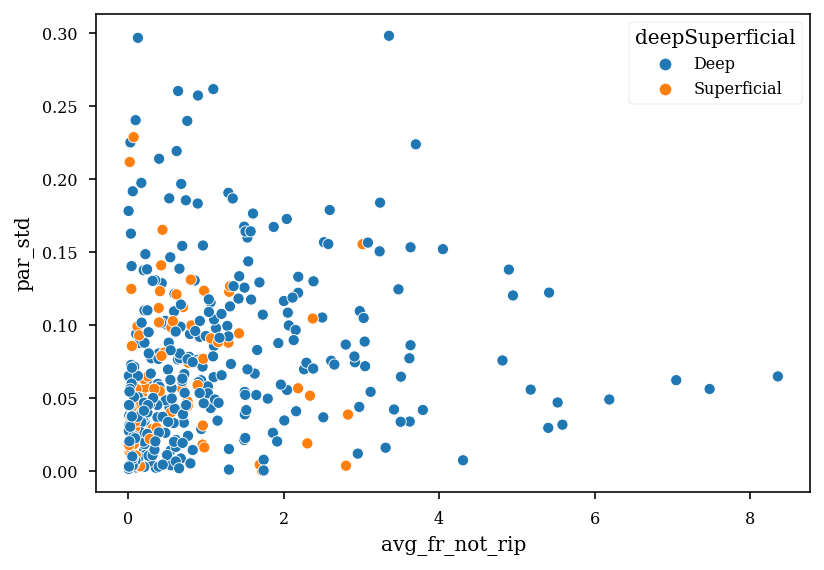

In [127]:
sns.scatterplot(x="avg_fr_not_rip", y="par_std",data=df_save,
                hue="deepSuperficial")

# plt.xscale('log')
# plt.yscale('log')

<AxesSubplot:xlabel='deepSuperficial', ylabel='par_std'>

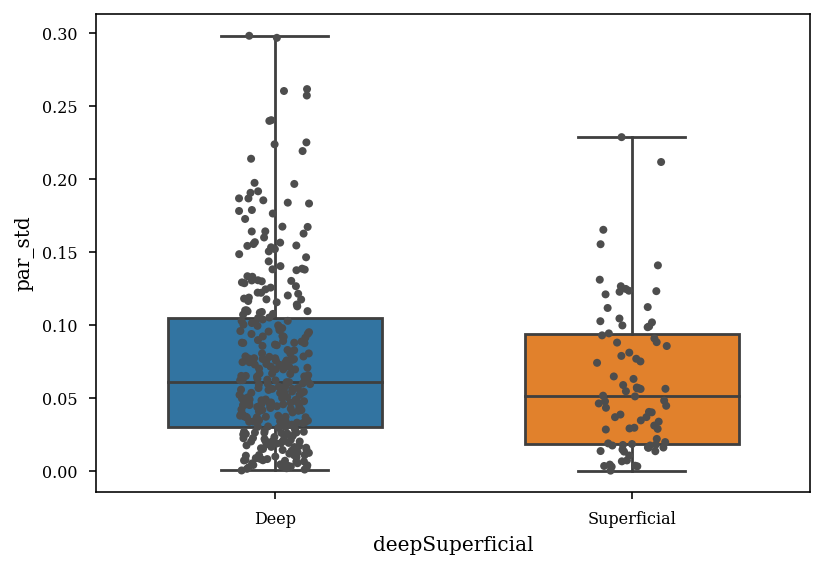

In [89]:
sns.boxplot(x="deepSuperficial", y="par_std", data=df_save,
            whis=[0, 100], width=.6)

sns.stripplot(x="deepSuperficial", y="par_std", data=df_save,
              size=4, color=".3", linewidth=0)

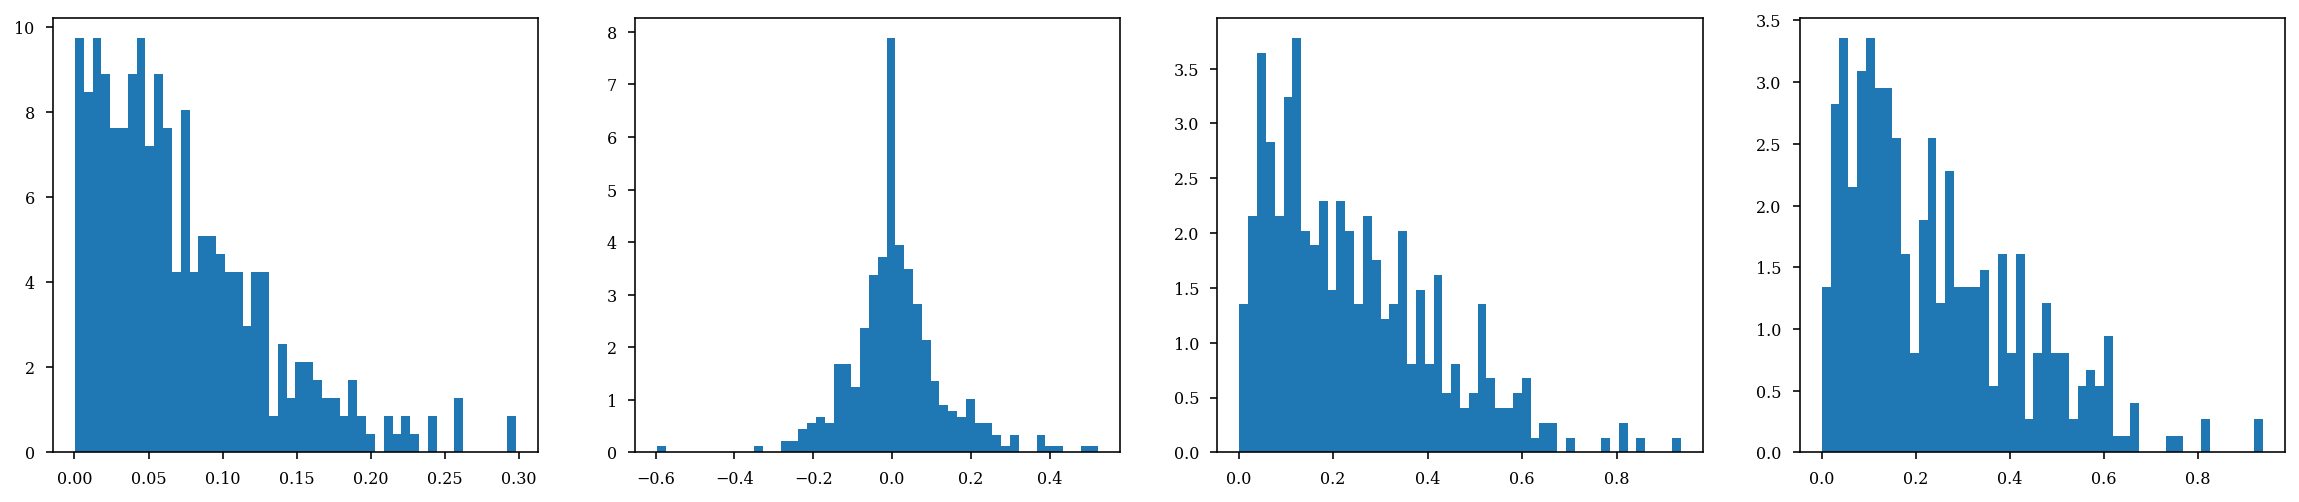

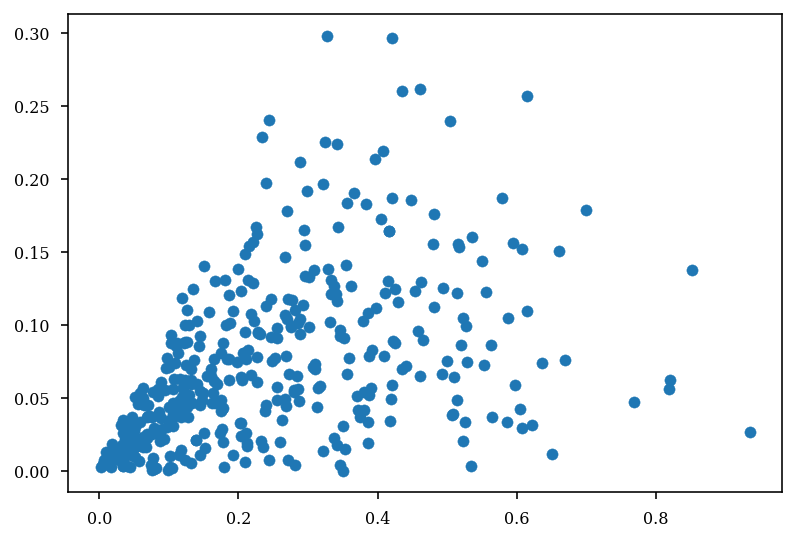

In [71]:
fig,ax = plt.subplots(1,4,figsize=(20,4))
ax[0].hist(df_save.par_std,50,density=True)
ax[1].hist(df_save.par_mean_diff,50,density=True)
ax[2].hist(df_save.par_mean,50,density=True)
ax[3].hist(df_save.par_median,50,density=True)
plt.show()


In [122]:
X_ = []
for u in range(df_save.shape[0]):
    X_.append(df[(df.basepath == df_save.iloc[u].basepath) & (df.UID == df_save.iloc[u].UID)].participation_prob.values)

X = np.zeros([len(X),5])
for i,x in enumerate(X_):
    X[i,0:len(x)] = x

<AxesSubplot:>

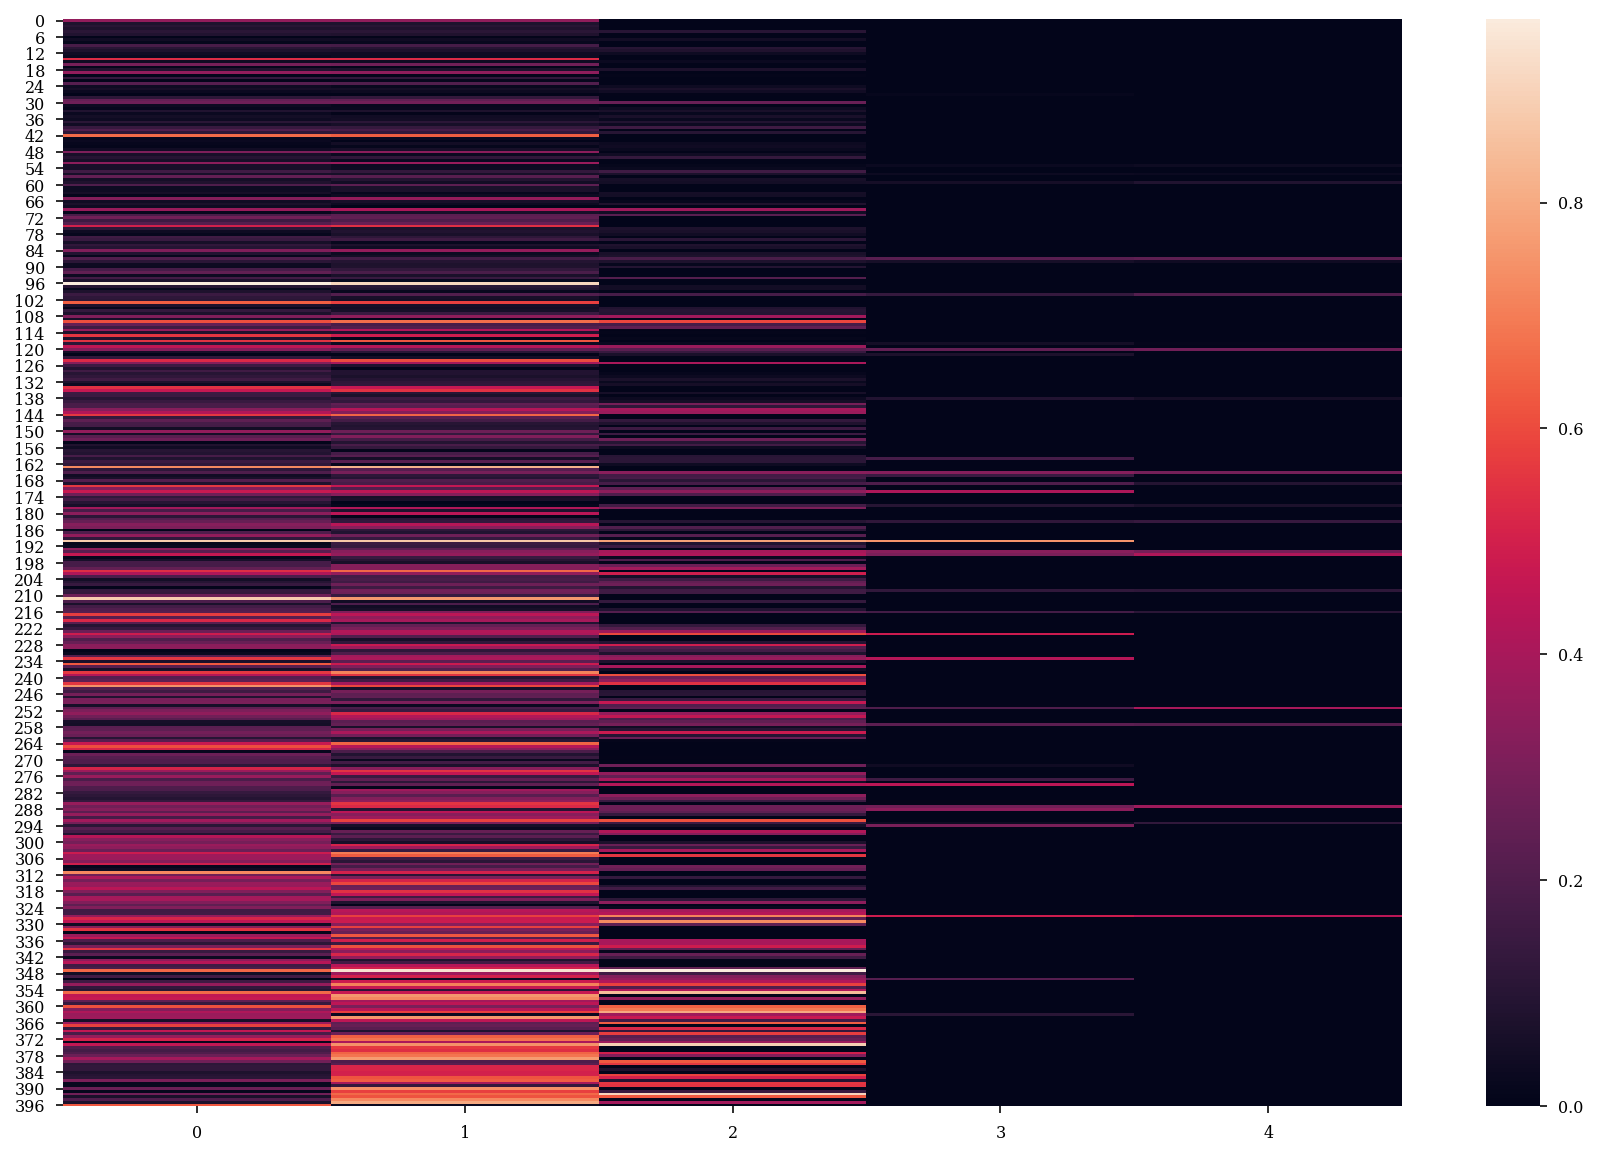

In [126]:
plt.figure(figsize=(15,10))
sns.heatmap(X[np.argsort(df_save.par_std)])

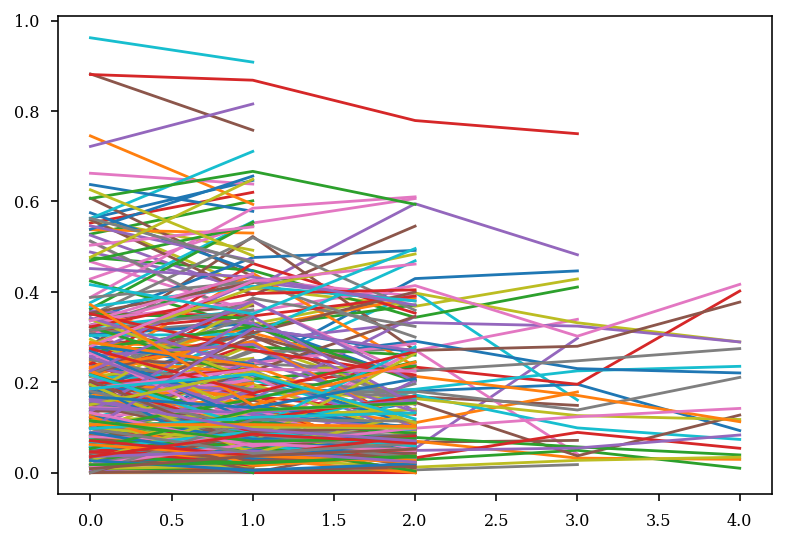

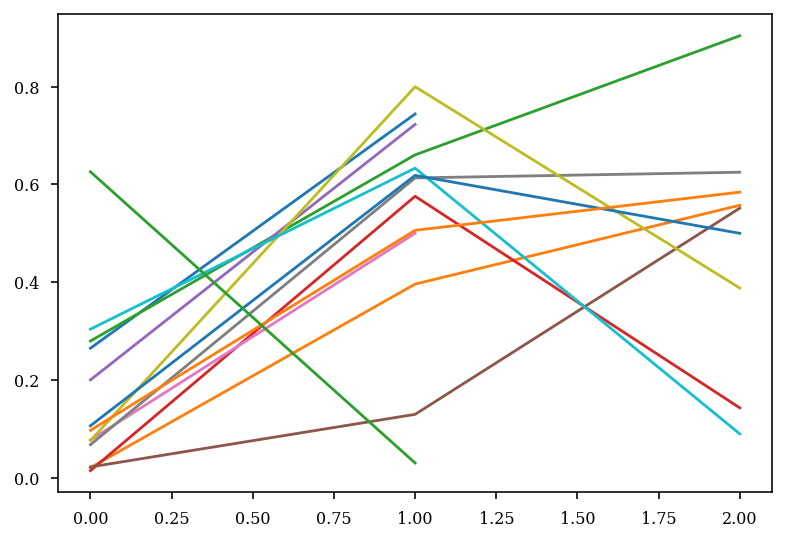

In [28]:
plt.figure()
unit_id = np.where(df_save.par_std < .1)[0]
for u in unit_id:
    plt.plot(df[(df.basepath == df_save.iloc[u].basepath) & (df.UID == df_save.iloc[u].UID)].participation_prob.values)

plt.figure()
unit_id = np.where(df_save.par_std > .2)[0]
for u in unit_id:
    plt.plot(df[(df.basepath == df_save.iloc[u].basepath) & (df.UID == df_save.iloc[u].UID)].participation_prob.values)

In [83]:
basepath = df_save[df_save.par_std < .05].basepath.values[0]
UID = df_save[df_save.par_std < .05].UID.values[0]

idx = np.where(df_save.par_std < .05)[0]
cell_metrics,data,ripples,fs_dat = load_basic_data(basepath)

epoch_df = loading.load_epoch(basepath)
epoch_df = compress_repeated_epochs(epoch_df)
# epoch_df = epoch_df[epoch_df.environment != "sleep"]
epoch_df

,name,startTime,stopTime,environment,behavioralParadigm
0,2006-6-12_14-35-5_sleep,0,2569.19,sleep,10
1,2006-6-12_15-55-31_linearOne,2569.19,3703.16,linearOne,10
2,2006-6-12_16-53-46_linearTwo,3703.16,4525.08,linearTwo,10
3,2006-6-12_17-20-33_sleep,4525.08,8640.21,sleep,10
4,2006-6-12_19-26-43_Tmaze,8640.21,10998.5,Tmaze,10
5,2006-6-12_20-52-46_sleep,10998.5,13540,sleep,10


In [84]:
df[(df.basepath == df_save.iloc[idx].basepath.values[0]) & (df.UID == df_save.iloc[idx].UID.values[0])]

,Unnamed: 0,UID,basepath,epoch,epoch_n,familiarity,deepSuperficial,brainRegion,putativeCellType,participation_prob,avg_fr_not_rip,avg_fr_in_rip,n_spikes,session_dur,n_ripples,unit_quality
564,30,45,Z:\Data\Kenji\2006-6-12,linearOne,1,10,Deep,CA1,Pyramidal Cell,0.048387,0.727307,0.646639,824.0,1133.9750,124,True
584,50,45,Z:\Data\Kenji\2006-6-12,linearTwo,2,10,Deep,CA1,Pyramidal Cell,0.095238,0.070081,1.400186,69.0,821.9185,105,True
624,90,45,Z:\Data\Kenji\2006-6-12,Tmaze,4,10,Deep,CA1,Pyramidal Cell,0.155650,0.480590,3.404567,1233.0,2358.2960,469,True


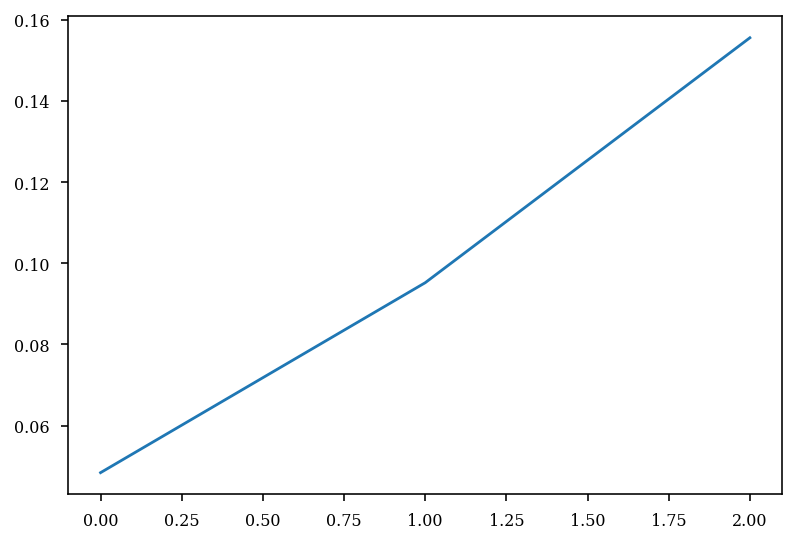

In [85]:
plt.plot(df[(df.basepath == df_save.iloc[idx].basepath.values[0]) & (df.UID == df_save.iloc[idx].UID.values[0])].participation_prob.values)


Text(0, 0.5, 'ripple n')

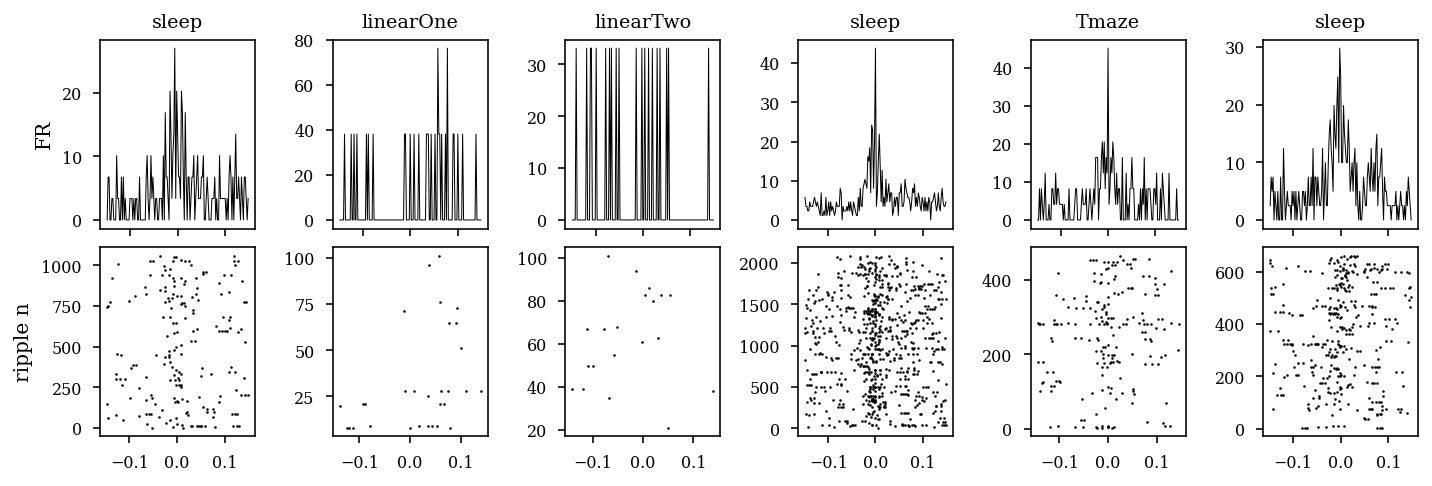

In [87]:
# from scipy.ndimage import gaussian_filter1d


def get_raster_points(spikes,peak_time,duration=0.150):
    ''' 
    create raster centered over each ripple with a 1 second window
    '''
    x = []
    y = []
    for i,r in enumerate(peak_time):
        idx = (spikes> r - duration) & (spikes < r + duration)
        cur_spks = spikes[idx]
        if any(cur_spks):
            x.append(cur_spks - r)
            y.append(np.ones_like(cur_spks)+i)       
    x = list(itertools.chain(*x))
    y = list(itertools.chain(*y))
    return x, y

def get_h0_z_energy(x,y,duration=0.150,bin_count=150,window=30):
     # bin cell into 5ms bins 
    bins = np.linspace(-duration,duration,bin_count)
    h0_counts, bin_edges = np.histogram(x, bins=bins)
    # normalize into firing rate
    h0 = h0_counts / (len(np.unique(y))*np.diff(bins)[0])
    # smooth to get expected firing rate
    hist_smooth = gaussian_filter1d(h0,window)
    # subtract the expected rates and devided by the standard deviation to get z-scored modulation
    z = (h0 - hist_smooth) / np.sqrt(hist_smooth)
    # Calculate the amplitude of the SWR modulation
    swr_energy = np.sqrt(sum(z**2))
    return h0, z, swr_energy, h0_counts

spikes = data['spikes'][np.where(cell_metrics.UID == UID)[0][0]]

def plot_psth(ripples,epoch_df,spikes,epoch_n,ax):
    duration = 0.150
    bin_count = 150
    bins_edges = np.linspace(-duration,duration,bin_count)
    bin_width = np.diff(bins_edges)[0]

    peak_time = ripples.peaks
    peak_time = peak_time[(peak_time >= epoch_df.iloc[epoch_n].startTime) & (peak_time <= epoch_df.iloc[epoch_n].stopTime)]
    x, y = get_raster_points(spikes,peak_time)  
    h0, z, swr_energy, h0_counts = get_h0_z_energy(x,y)

    ax[epoch_n].plot(bins_edges[:-1]+bin_width/2,h0,color='k',linewidth=.5)
    ax[epoch_n+epoch_df.shape[0]].scatter(x,y,color='k',s=1,rasterized=True)

    ax[epoch_n].set_title(epoch_df.iloc[epoch_n].environment)

fig, axs = plt.subplots(2,epoch_df.shape[0], figsize=functions.set_size('thesis', fraction=2, subplots=(3, epoch_df.shape[0])), edgecolor='k')
fig.subplots_adjust(hspace = 0.1, wspace=.5)
axs = axs.ravel()

for epoch_n in range(epoch_df.shape[0]):
    plot_psth(ripples,epoch_df,spikes,epoch_n,axs)
axs[0].set_ylabel('FR')
axs[epoch_df.shape[0]].set_ylabel('ripple n')

# plt.savefig(os.path.join(fig_save_path,'participation_over_epoch_example.pdf'),dpi=300,bbox_inches='tight')


In [382]:
(len(y))

3304

array([   65.6984,    65.804 ,    84.528 ,    94.57  ,    99.3772,
         106.542 ,   115.2724,   129.7256,   143.7252,   143.9076,
         149.0108,   151.4892,   163.3656,   203.554 ,   205.0388,
         206.272 ,   207.4132,   210.5728,   211.1612,   224.5832,
         228.0156,   228.6572,   230.1224,   250.0652,   250.834 ,
         257.5568,   263.9688,   267.5504,   270.0624,   278.8792,
         280.43  ,   288.4796,   294.9532,   311.08  ,   317.3524,
         320.222 ,   321.7432,   322.4684,   322.6468,   328.8116,
         345.5372,   359.4876,   359.6896,   360.7824,   366.0976,
         368.756 ,   372.4576,   373.06  ,   377.686 ,   377.8352,
         382.8944,   385.1708,   385.3092,   386.4168,   395.348 ,
         409.7388,   425.8   ,   429.5076,   430.4012,   432.9624,
         433.6808,   436.1016,   439.5228,   451.3524,   454.1836,
         454.9444,   455.998 ,   473.4304,   474.7084,   488.8512,
         488.9772,   490.0056,   490.0964,   490.6304,   500.5

In [205]:
n_units = []
for basepath in df.basepath:
    n_units.append(df[(df.basepath == basepath) & (df.epoch_n == df[df.basepath == basepath].epoch_n.iloc[0])].shape[0])

In [198]:
def pairwise_corr(df):
    x = df.epoch_n.unique()
    c = np.array(list(itertools.combinations(x, 2)))
    rho = []
    pval = []
    for i,s in enumerate(c):	
        rho_, pval_ = stats.spearmanr(df[df.epoch_n==s[0]].participation_prob,
                                        df[df.epoch_n==s[1]].participation_prob)
        rho.append(rho_)
        pval.append(pval_)
    return rho,pval,c


df_save = pd.DataFrame()
for basepath in df[np.array(n_units)>=7].basepath.unique():
    if df[(df.basepath == basepath)].epoch_n.unique().shape[0] > 1:
        rho,pval,c = pairwise_corr(df[(df.basepath == basepath)])

        temp_df = pd.DataFrame()

        temp_df['ref'] = c[:,0]
        temp_df['target'] = c[:,1]
        temp_df['rho'] = rho
        temp_df['pval'] = pval
        temp_df['basepath'] = basepath

        df_save = df_save.append(temp_df,ignore_index=True)
df_save

,ref,target,rho,pval,basepath
0,1,2,1.000000,0.000000e+00,Z:\Data\Kenji\ec013.152_157
1,1,3,0.842424,2.220031e-03,Z:\Data\Kenji\ec013.194_213
2,1,3,0.835400,7.167851e-04,Z:\Data\Kenji\ec013.370_390
3,1,5,0.676073,1.579277e-02,Z:\Data\Kenji\ec013.370_390
4,1,6,0.767625,3.557617e-03,Z:\Data\Kenji\ec013.370_390
...,...,...,...,...,...
101,0,2,0.229622,4.504500e-01,Z:\Data\Kenji\i01_maze04_MS.001_003
102,0,2,0.521946,5.001885e-06,Z:\Data\Kenji\i01_maze05_MS.001_003
103,0,1,0.477707,5.956352e-04,Z:\Data\Kenji\i01_maze15_MS.001_004
104,0,2,0.519511,1.544166e-04,Z:\Data\Kenji\i01_maze15_MS.001_004


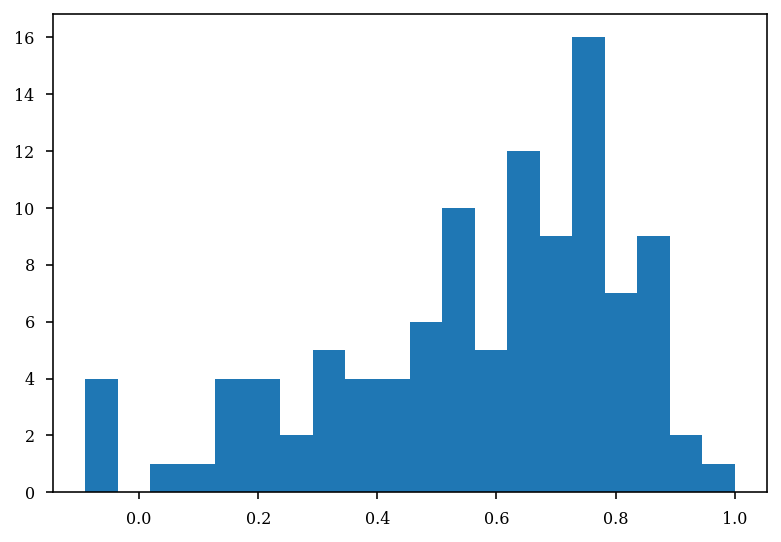

In [199]:
plt.hist(df_save.rho,20)
plt.show()

Z:\Data\Kenji\ec013.393_418


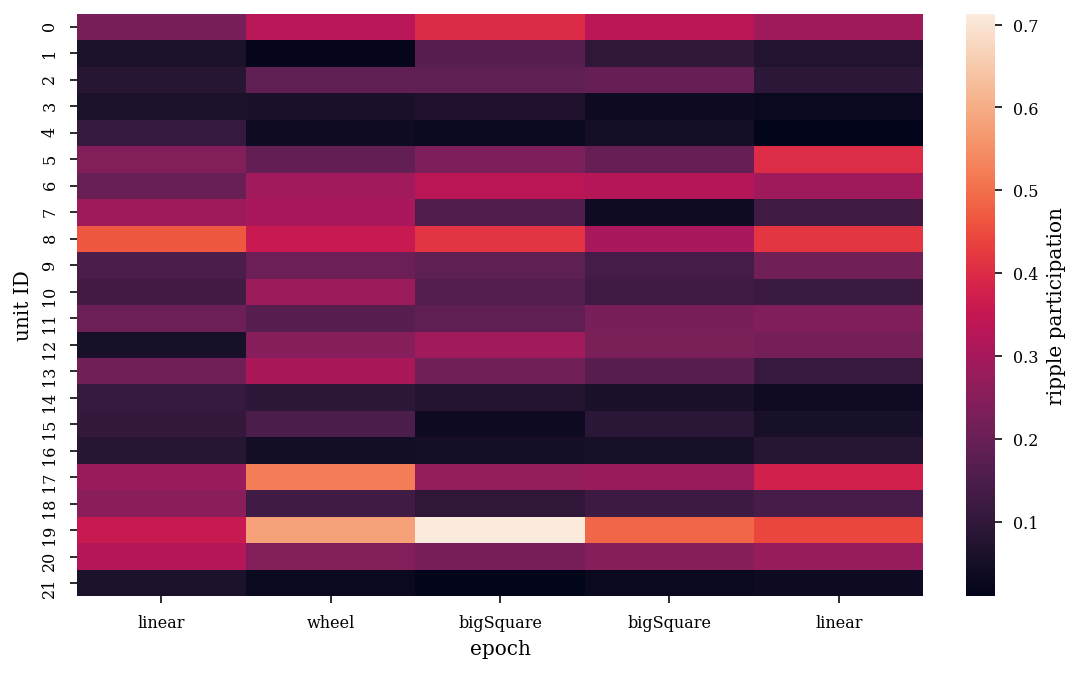

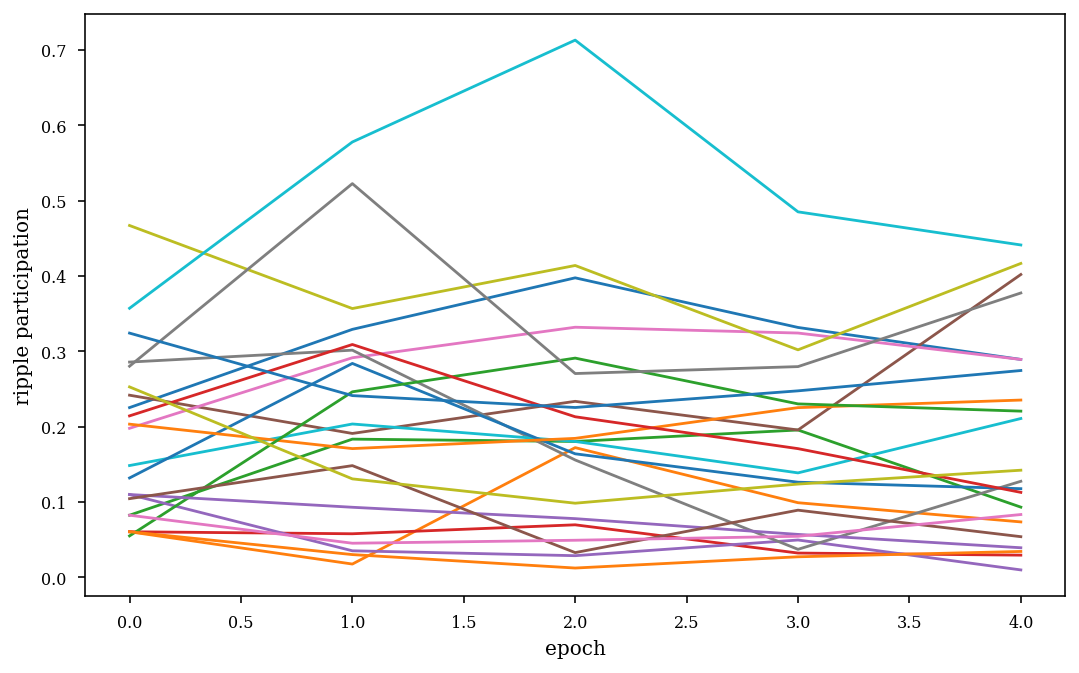

In [220]:
basepath = df[np.array(n_units)>=7].basepath.unique()[3]

print(basepath)
epoch_df = loading.load_epoch(basepath)

temp_df = df[df.basepath == basepath]
X = np.zeros([temp_df.epoch_n.unique().shape[0],temp_df.UID.unique().shape[0]])
for i,ep in enumerate(temp_df.epoch_n.unique()):
    X[i,:] = temp_df[temp_df.epoch_n == ep].participation_prob.values

epoch_name = [temp_df[temp_df.epoch_n == ep_n].epoch.unique()[0] for ep_n in temp_df.epoch_n.unique()]

X_df = pd.DataFrame(index = np.arange(X.shape[1]), columns = epoch_name)
X_df[:] = X.T

# plt.figure(figsize=(15,8))
plt.figure(figsize=functions.set_size('thesis', fraction=1.25, subplots=(1, 1)), edgecolor='k',constrained_layout=True)
sns.heatmap(X_df,cbar_kws={'label': 'ripple participation'})
plt.ylabel('unit ID')
plt.xlabel('epoch')   

plt.figure(figsize=functions.set_size('thesis', fraction=1.25, subplots=(1, 1)), edgecolor='k',constrained_layout=True)
plt.plot(X_df.values.T)
plt.ylabel('ripple participation')
plt.xlabel('epoch')
plt.show()

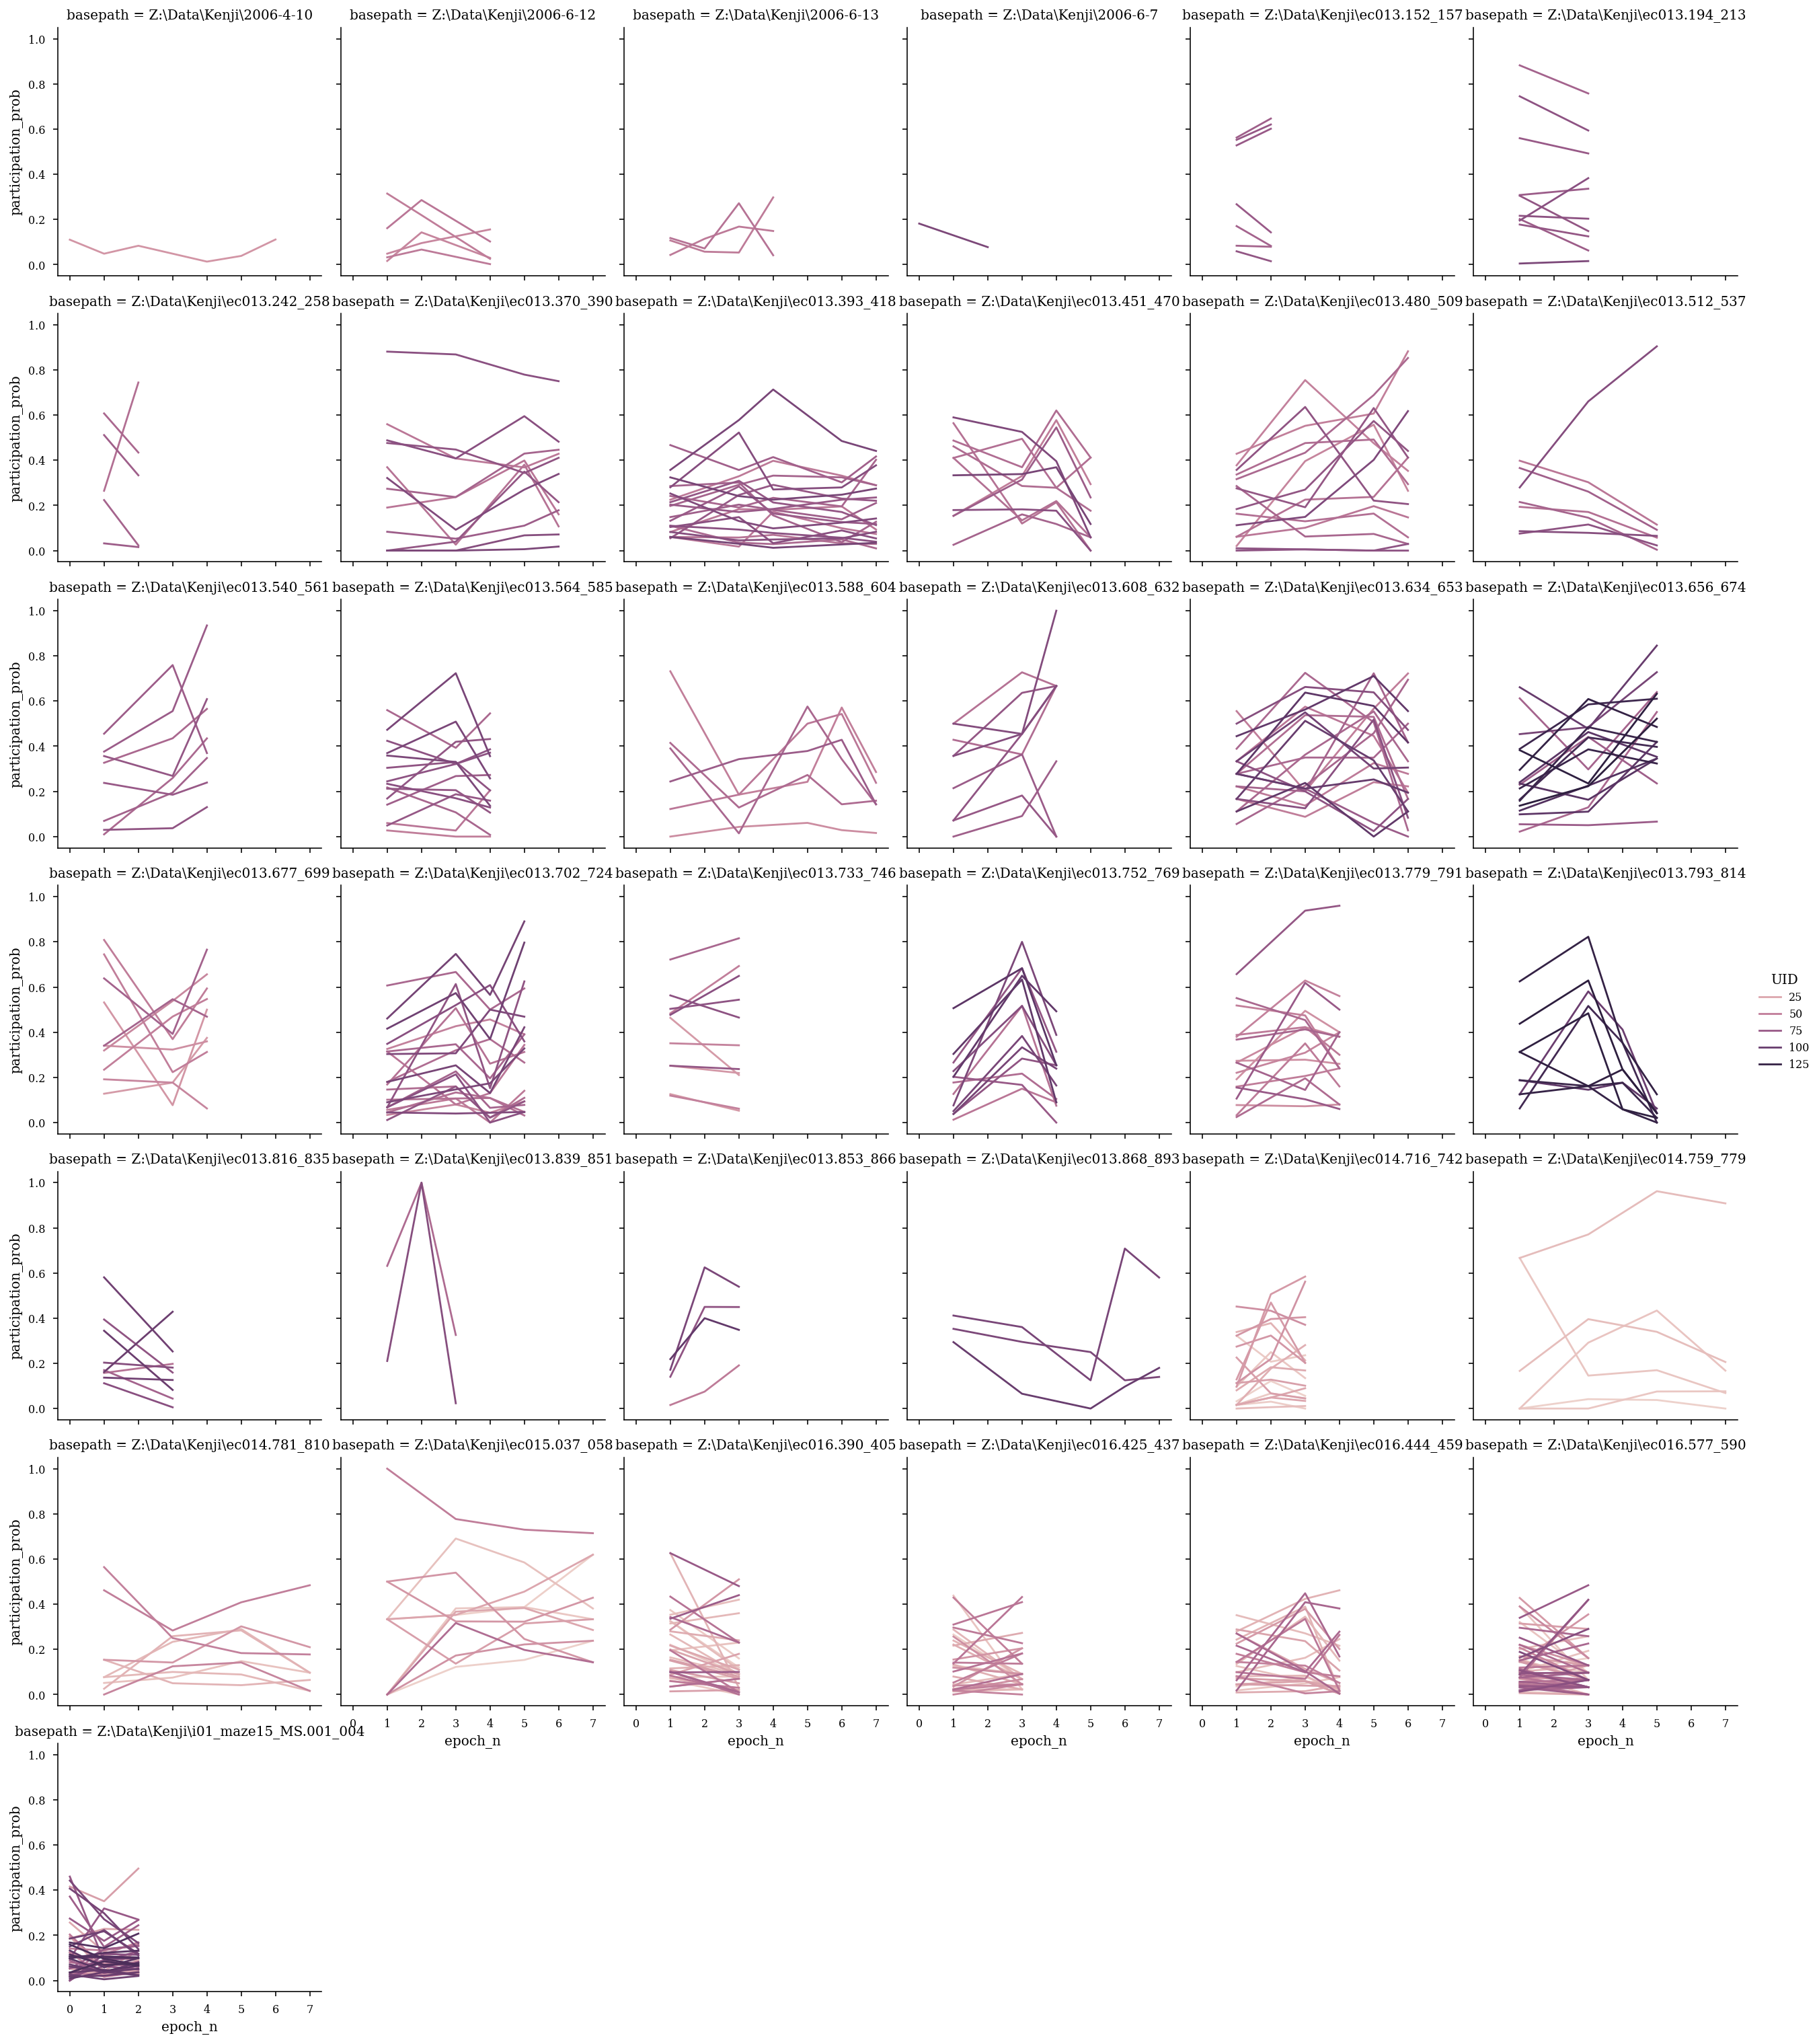

In [225]:
palette = sns.color_palette("rocket_r")

sns.relplot(
    data=df,
    x="epoch_n", y="participation_prob",
    kind="line", col="basepath",hue="UID",
    height=3, aspect=1,col_wrap=6
)